In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import keras as krs
from keras.models import Sequential
from keras.layers import Dense 
from keras.optimizers import SGD

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

In [2]:
dataset = pd.read_csv("full_cohort_data.csv")
# Verisetinde bu 2 özniteliğin nümerik değerlere sahip 'day_icu_intime_num' ve 'service_num' öznitelikleri olduğundan veri setinden çıkartılması.
dataset=dataset.drop('day_icu_intime',axis=1)
dataset=dataset.drop('service_unit',axis=1)

In [3]:
# Verisetindeki özniteliklerin içerdiği null değerlerin sayısı.
dataset.isnull().sum()

aline_flg               0
icu_los_day             0
hospital_los_day        0
age                     0
gender_num              1
weight_first          110
bmi                   466
sapsi_first            85
sofa_first              6
service_num             0
day_icu_intime_num      0
hour_icu_intime         0
hosp_exp_flg            0
icu_exp_flg             0
day_28_flg              0
mort_day_censored       0
censor_flg              0
sepsis_flg              0
chf_flg                 0
afib_flg                0
renal_flg               0
liver_flg               0
copd_flg                0
cad_flg                 0
stroke_flg              0
mal_flg                 0
resp_flg                0
map_1st                 0
hr_1st                  0
temp_1st                3
spo2_1st                0
abg_count               0
wbc_first               8
hgb_first               8
platelet_first          8
sodium_first            5
potassium_first         5
tco2_first              5
chloride_fir

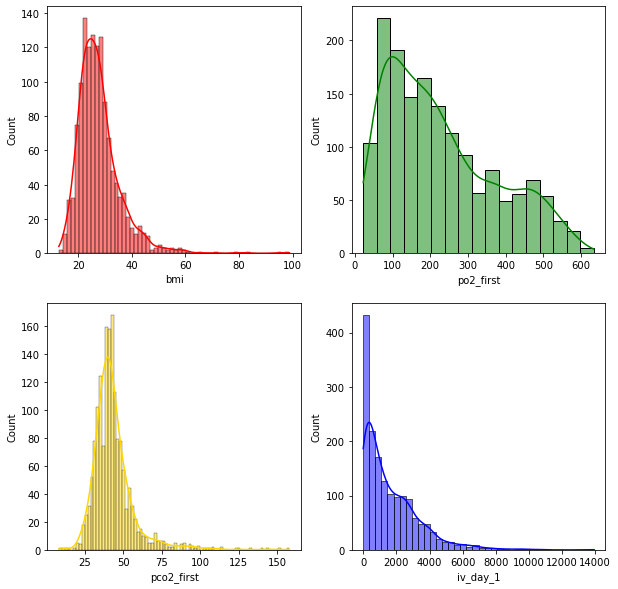

In [4]:
# Verisetinde en fazla NaN değerlere sahip 4 özniteliğinin veri dağılımı.
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
sns.histplot(data=dataset, x="bmi",kde=True, color="red", ax=axs[0, 0])
sns.histplot(data=dataset, x="po2_first", kde=True, color="green", ax=axs[0, 1])
sns.histplot(data=dataset, x="pco2_first", kde=True, color="gold", ax=axs[1, 0])
sns.histplot(data=dataset, x="iv_day_1", kde=True, color="blue", ax=axs[1, 1])
plt.show()

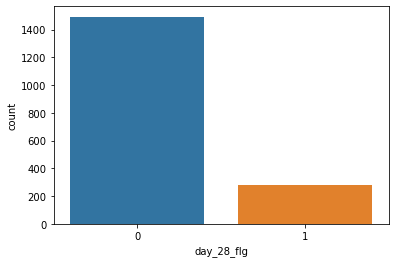

In [5]:
# NaN değerler içeren verilerin dağılımı genelde sağ taraftan basık olduğundan NaN değerler median değerleri ile doldurulur.
dataset = dataset.fillna(dataset.median())

# Sınıflandırma yaptığımız 'day_28_flg' özniteliğinin 0 ve 1 değerlerinin dağılımı.
ax = sns.countplot(x="day_28_flg", data=dataset)

In [6]:
# Sınıflandırma yaptığımız 'day_28_flg' özniteliğinin 1 ve 0 değerlerini aldığu veriler arasında
# büyük bir fark olduğundan değeri 1 olan verilerin day_28_1'e atanması
day_28_1 = dataset.loc[dataset['day_28_flg'] == 1]

In [7]:
# 'day_28_flg' öznitelik değeri 0 yani hayatta olan hastaların verilerinin day_28_0'a atanması
day_28_0 = dataset.loc[dataset['day_28_flg'] == 0]

# 'day_28_flg' özniteliği ile eşit sayıda 0 değerine sahip, verisetinden rastgele seçilmiş verilerin day_28_0'a atanması.
day_28_0 = day_28_0.sample(n=283,replace=False)

In [8]:
# Sınıflandırma yaptığımız 'day_28_flg' özniteliği eşit sayıda 0 ve 1 içeren verisetinin oluşturulması
result = pd.concat([day_28_1,day_28_0])
result

,aline_flg,icu_los_day,hospital_los_day,age,gender_num,weight_first,bmi,sapsi_first,sofa_first,service_num,...,platelet_first,sodium_first,potassium_first,tco2_first,chloride_first,bun_first,creatinine_first,po2_first,pco2_first,iv_day_1
0,1,7.63,13,72.36841,1.0,75.0,29.912791,15.0,9.0,1,...,354.0,138.0,4.6,15.0,109.0,41.0,1.6,196.0,39.0,2230.875000
3,1,0.58,3,44.49191,0.0,77.0,26.324846,21.0,7.0,1,...,262.0,139.0,4.2,31.0,100.0,16.0,0.5,146.0,23.0,1081.529175
9,1,7.14,7,25.41667,0.0,61.5,21.543184,13.0,9.0,0,...,137.0,143.0,3.7,28.0,104.0,2.0,0.3,284.0,33.0,3593.863770
17,0,0.51,1,90.37012,0.0,77.0,26.324846,14.0,4.0,0,...,248.0,139.0,5.0,22.0,102.0,15.0,1.0,459.0,30.0,1081.529175
21,1,2.61,10,79.58333,1.0,91.4,28.103607,19.0,10.0,0,...,231.0,141.0,4.3,30.0,99.0,37.0,2.1,230.0,78.0,1062.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,1,1.58,10,47.21768,0.0,88.6,28.026587,16.0,6.0,1,...,243.0,141.0,3.7,20.0,109.0,12.0,0.6,146.0,41.0,3032.161621
1706,0,3.99,5,79.34041,0.0,59.2,26.324846,15.0,6.0,0,...,173.0,141.0,4.8,26.0,105.0,31.0,1.5,127.0,50.0,2657.250000
1492,0,1.51,3,72.08100,0.0,129.0,26.324846,13.0,6.0,1,...,173.0,139.0,4.1,27.0,101.0,27.0,1.8,571.0,40.0,1623.444946
1045,0,3.44,17,46.23701,0.0,64.0,26.650427,14.0,5.0,1,...,235.0,139.0,3.0,30.0,101.0,10.0,0.6,195.0,41.0,1799.200317


In [9]:
# Üzerinde sınıflandırma yaptığımız 'day_28_flg' özniteliğinin y_total değişkenine diğer tüm özniteliklerin ise x_total değişkenine atanması.
X_total = result.iloc[:,[x for x in range(0,44) if x !=14]]
Y_total = result.iloc[:,14]

# Verilerin %20 Test %80 Train olarak ayrılması.
X_train, X_test, Y_train, Y_test = train_test_split(X_total, Y_total, test_size = 0.2, random_state = 0)

# Verilerin normalizasyonu. (Binary classification yaptığımızdan tüm veriler 0 ile 1 arasında normalize edilmelidir.)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
plt.rcParams["figure.figsize"] = (16,13)

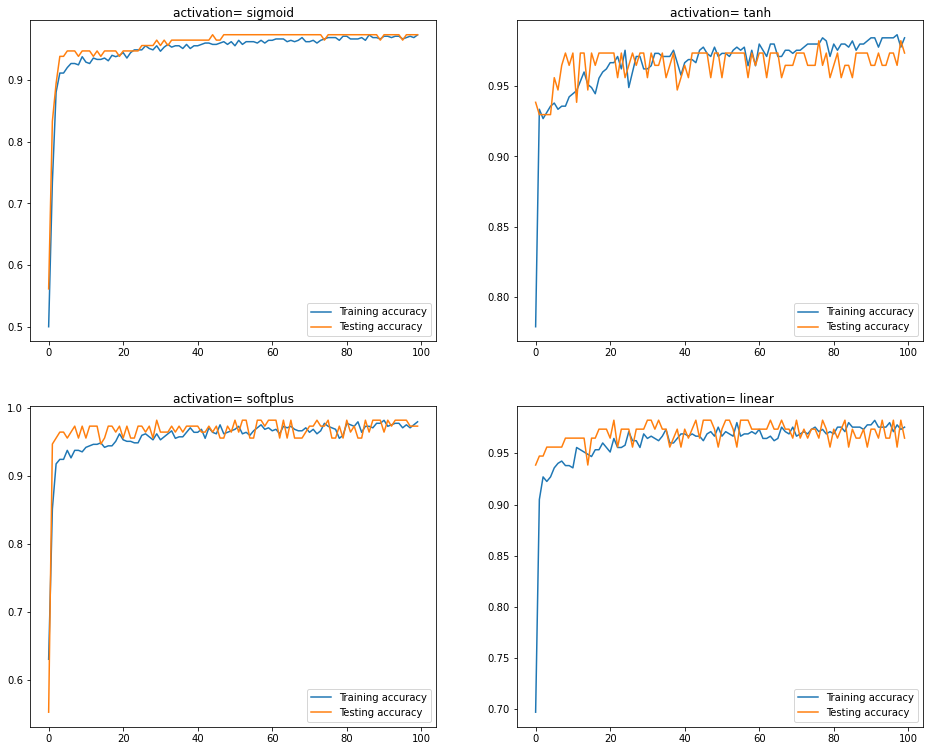

In [10]:
# Gizli katmanlar için Sigmoid, Hiperbolik tanjant, Softplus ve Linear aktivasyon fonksiyonlarının
# her biri için yapay sinir ağları modelinin doğruluk değerlerinin grafiğinin çizdirilmesi.
def fit_model(X_train, Y_train, X_test, Y_test, function):
	model = krs.models.Sequential()
	model.add(krs.layers.Dense(12, activation=function, input_dim=43))
	model.add(krs.layers.Dense(1, activation='sigmoid'))
	optimizer = SGD(lr=0.01,momentum=0.9)
	model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy'])
	history = model.fit(X_train, Y_train, validation_data=(X_test,Y_test), epochs=100,batch_size=16, verbose=0)
	plt.plot(history.history['accuracy'], label='Training accuracy')
	plt.plot(history.history['val_accuracy'], label='Testing accuracy')
	plt.legend(loc='lower right')
	plt.title('activation= '+str(function), pad=-80)

functions = ['sigmoid', 'tanh', 'softplus', 'linear']
for i in range(len(functions)):
	plot_no = 220 + (i+1)
	plt.subplot(plot_no)
	fit_model(X_train, Y_train, X_test, Y_test, functions[i])

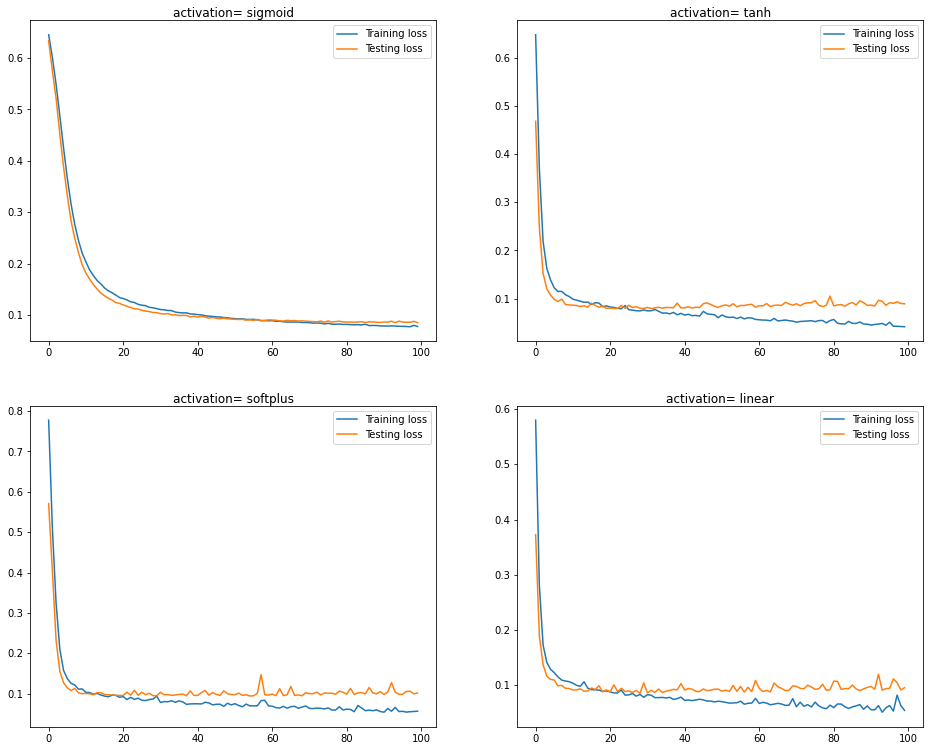

In [11]:
# Gizli katmanlar için Sigmoid, Hiperbolik tanjant, Softplus ve Linear aktivasyon fonksiyonlarının
# her biri için yapay sinir ağları modelinin hata değerlerinin grafiğinin çizdirilmesi.
def fit_model(X_train, Y_train, X_test, Y_test, function):
	model = krs.models.Sequential()
	model.add(krs.layers.Dense(12, activation=function, input_dim=43))
	model.add(krs.layers.Dense(1, activation='sigmoid'))
	optimizer = SGD(lr=0.01,momentum=0.9)
	model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy'])
	history = model.fit(X_train, Y_train, validation_data=(X_test,Y_test), epochs=100,batch_size=16, verbose=0)
	plt.plot(history.history['loss'], label='Training loss')
	plt.plot(history.history['val_loss'], label='Testing loss')
	plt.legend(loc='upper right')
	plt.title('activation= '+str(function), pad=-80)

functions = ['sigmoid', 'tanh', 'softplus', 'linear']
for i in range(len(functions)):
	plot_no = 220 + (i+1)
	plt.subplot(plot_no)
	fit_model(X_train, Y_train, X_test, Y_test, functions[i])

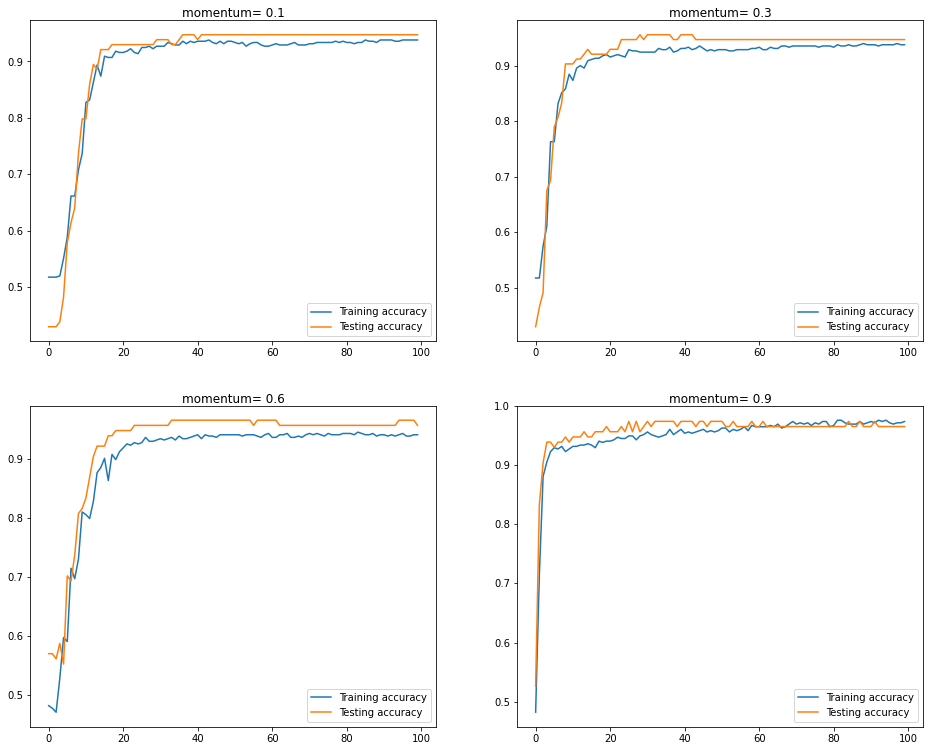

In [12]:
# Sigmoid aktivasyon fonksiyonu seçildikten sonra 0.01 öğrenme oranına göre farklı momentum katsayılarının
# her biri için yapay sinir ağları modelinin doğruluk değerlerinin grafiğinin çizdirilmesi.
def fit_model(X_train, Y_train, X_test, Y_test, momentum):
	model = krs.models.Sequential()
	model.add(krs.layers.Dense(12, activation='sigmoid', input_dim=43))
	model.add(krs.layers.Dense(1, activation='sigmoid'))
	optimizer = SGD(lr=0.01,momentum=momentum)
	model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy'])
	history = model.fit(X_train, Y_train, validation_data=(X_test,Y_test), epochs=100,batch_size=16, verbose=0)
	plt.plot(history.history['accuracy'], label='Training accuracy')
	plt.plot(history.history['val_accuracy'], label='Testing accuracy')
	plt.legend(loc='lower right')
	plt.title('momentum= '+str(momentum), pad=-180)

momentums = [0.1,0.3,0.6,0.9]
for i in range(len(momentums)):
	plot_no = 220 + (i+1)
	plt.subplot(plot_no)
	fit_model(X_train, Y_train, X_test, Y_test, momentums[i])

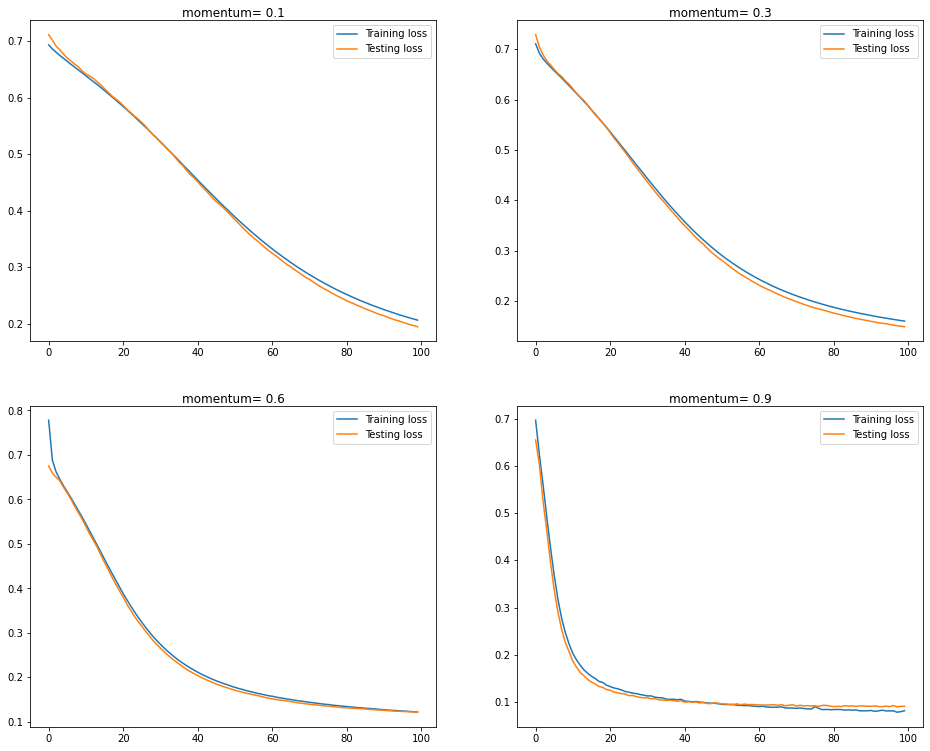

In [13]:
# Sigmoid aktivasyon fonksiyonu ve 0.01 öğrenme oranına göre farklı momentum katsayılarının
# her biri için yapay sinir ağları modelinin hata değerlerinin grafiğinin çizdirilmesi.
def fit_model(X_train, Y_train, X_test, Y_test, momentum):   
	model = krs.models.Sequential()
	model.add(krs.layers.Dense(12, activation='sigmoid', input_dim=43))
	model.add(krs.layers.Dense(1, activation='sigmoid'))
	optimizer = SGD(lr=0.01,momentum=momentum)
	model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy'])
	history = model.fit(X_train, Y_train, validation_data=(X_test,Y_test), epochs=100,batch_size=16, verbose=0)
	plt.plot(history.history['loss'], label='Training loss')
	plt.plot(history.history['val_loss'], label='Testing loss')
	plt.legend(loc='upper right')
	plt.title('momentum= '+str(momentum), pad=-180)

momentums = [0.1,0.3,0.6,0.9]
for i in range(len(momentums)):
	plot_no = 220 + (i+1)
	plt.subplot(plot_no)
	fit_model(X_train, Y_train, X_test, Y_test, momentums[i])

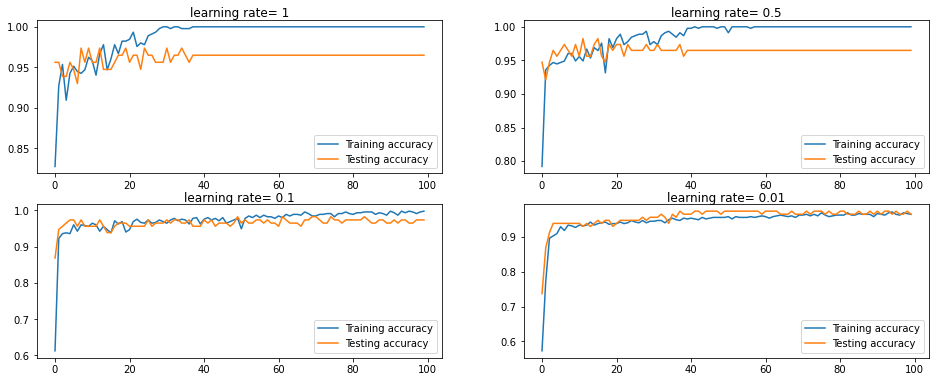

In [14]:
# Sigmoid aktivasyon fonksiyonu ve 0.9 momentum katsayına sahip farklı öğrenme oranlarının
# her biri için yapay sinir ağları modelinin doğruluk değerlerinin grafiğinin çizdirilmesi.
def fit_model(X_train, Y_train, X_test, Y_test, lrate):
	model = krs.models.Sequential()
	model.add(krs.layers.Dense(12, activation='sigmoid', input_dim=43))
	model.add(krs.layers.Dense(1, activation='sigmoid'))
	optimizer = SGD(lr=lrate,momentum=0.9)
	model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy'])
	history = model.fit(X_train, Y_train, validation_data=(X_test,Y_test), epochs=100,batch_size=16, verbose=0)
	plt.plot(history.history['accuracy'], label='Training accuracy')
	plt.plot(history.history['val_accuracy'], label='Testing accuracy')
	plt.legend(loc='lower right')
	plt.title('learning rate= '+str(lrate), pad=-50)
 
learning_rates = [1, 0.5, 0.1, 0.01]
for i in range(len(learning_rates)):
	plot_no = 420 + (i+1)
	plt.subplot(plot_no)
	fit_model(X_train, Y_train, X_test, Y_test, learning_rates[i])

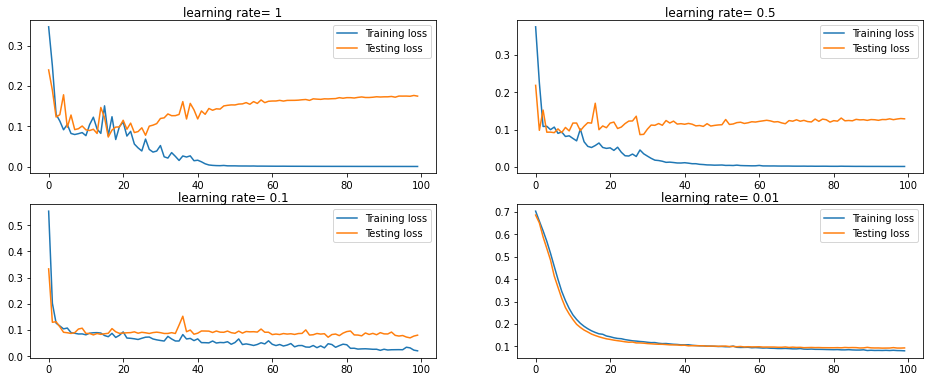

In [15]:
# Sigmoid aktivasyon fonksiyonu ve 0.9 momentum katsayına sahip farklı öğrenme oranlarının
# her biri için yapay sinir ağları modelinin hata değerlerinin grafiğinin çizdirilmesi.
def fit_model(X_train, Y_train, X_test, Y_test, lrate):
	model = krs.models.Sequential()
	model.add(krs.layers.Dense(12, activation='sigmoid', input_dim=43))
	model.add(krs.layers.Dense(1, activation='sigmoid'))
	optimizer = SGD(lr=lrate,momentum=0.9)
	model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy'])
	history = model.fit(X_train, Y_train, validation_data=(X_test,Y_test), epochs=100,batch_size=16, verbose=0)
	plt.plot(history.history['loss'], label='Training loss')
	plt.plot(history.history['val_loss'], label='Testing loss')
	plt.legend(loc='upper right')
	plt.title('learning rate= '+str(lrate), pad=-50)

learning_rates = [1, 0.5, 0.1, 0.01]
for i in range(len(learning_rates)):
	plot_no = 420 + (i+1)
	plt.subplot(plot_no)
	fit_model(X_train, Y_train, X_test, Y_test, learning_rates[i])

Epoch 1/100
15/15 - 0s - loss: 0.8315 - accuracy: 0.4823 - val_loss: 0.6776 - val_accuracy: 0.5702
Epoch 2/100
15/15 - 0s - loss: 0.6749 - accuracy: 0.5730 - val_loss: 0.7016 - val_accuracy: 0.4298
Epoch 3/100
15/15 - 0s - loss: 0.6585 - accuracy: 0.5177 - val_loss: 0.6589 - val_accuracy: 0.4737
Epoch 4/100
15/15 - 0s - loss: 0.6290 - accuracy: 0.8142 - val_loss: 0.6089 - val_accuracy: 0.9474
Epoch 5/100
15/15 - 0s - loss: 0.6032 - accuracy: 0.9204 - val_loss: 0.5842 - val_accuracy: 0.9474
Epoch 6/100
15/15 - 0s - loss: 0.5741 - accuracy: 0.9071 - val_loss: 0.5706 - val_accuracy: 0.9123
Epoch 7/100
15/15 - 0s - loss: 0.5455 - accuracy: 0.9270 - val_loss: 0.5275 - val_accuracy: 0.9561
Epoch 8/100
15/15 - 0s - loss: 0.5145 - accuracy: 0.9292 - val_loss: 0.4974 - val_accuracy: 0.9474
Epoch 9/100
15/15 - 0s - loss: 0.4829 - accuracy: 0.9336 - val_loss: 0.4652 - val_accuracy: 0.9561
Epoch 10/100
15/15 - 0s - loss: 0.4505 - accuracy: 0.9336 - val_loss: 0.4311 - val_accuracy: 0.9561
Epoch 11/

Epoch 84/100
15/15 - 0s - loss: 0.0983 - accuracy: 0.9624 - val_loss: 0.0977 - val_accuracy: 0.9737
Epoch 85/100
15/15 - 0s - loss: 0.0980 - accuracy: 0.9580 - val_loss: 0.0972 - val_accuracy: 0.9737
Epoch 86/100
15/15 - 0s - loss: 0.0974 - accuracy: 0.9602 - val_loss: 0.0976 - val_accuracy: 0.9737
Epoch 87/100
15/15 - 0s - loss: 0.0972 - accuracy: 0.9646 - val_loss: 0.0974 - val_accuracy: 0.9737
Epoch 88/100
15/15 - 0s - loss: 0.0969 - accuracy: 0.9624 - val_loss: 0.0970 - val_accuracy: 0.9737
Epoch 89/100
15/15 - 0s - loss: 0.0966 - accuracy: 0.9624 - val_loss: 0.0967 - val_accuracy: 0.9737
Epoch 90/100
15/15 - 0s - loss: 0.0962 - accuracy: 0.9646 - val_loss: 0.0972 - val_accuracy: 0.9737
Epoch 91/100
15/15 - 0s - loss: 0.0961 - accuracy: 0.9624 - val_loss: 0.0967 - val_accuracy: 0.9737
Epoch 92/100
15/15 - 0s - loss: 0.0955 - accuracy: 0.9624 - val_loss: 0.0949 - val_accuracy: 0.9649
Epoch 93/100
15/15 - 0s - loss: 0.0954 - accuracy: 0.9602 - val_loss: 0.0958 - val_accuracy: 0.9737


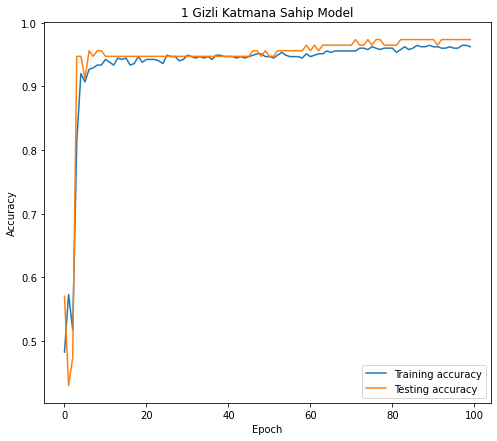

In [16]:
# Sigmoid aktivasyon fonksiyonu,0.9 momentum katsayısı ve 0.01 öğrenme oranına sahip 
# 1 gizli katmanlı yapay sinir ağları modelinin doğruluk değerinin grafiğinin çizdirilmesi
model1 = krs.models.Sequential()
model1.add(krs.layers.Dense(units=12,activation="sigmoid", input_dim=43))
model1.add(krs.layers.Dense(units=1,activation="sigmoid"))
optimizer = SGD(lr=0.01,momentum=0.9)
model1.compile(optimizer=optimizer,loss="binary_crossentropy",metrics=['accuracy'])

hist1 = model1.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=32 ,verbose=2)
plt.rcParams["figure.figsize"] = (8,7)
plt.plot(hist1.history['accuracy'], label='Training accuracy')
plt.plot(hist1.history['val_accuracy'], label='Testing accuracy')
plt.title('1 Gizli Katmana Sahip Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

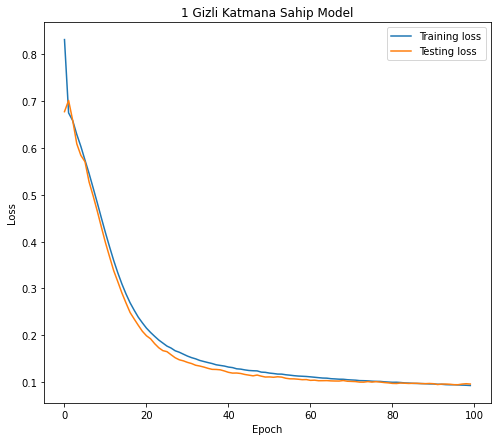

In [22]:
# Sigmoid aktivasyon fonksiyonu,0.9 momentum katsayısı ve 0.01 öğrenme oranına sahip 
# 1 gizli katmanlı yapay sinir ağları modelinin hata değerinin grafiğinin çizdirilmesi
plt.plot(hist1.history['loss'], label='Training loss')
plt.plot(hist1.history['val_loss'], label='Testing loss')
plt.title('1 Gizli Katmana Sahip Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

Epoch 1/100
15/15 - 0s - loss: 0.6955 - accuracy: 0.5177 - val_loss: 0.7095 - val_accuracy: 0.4298
Epoch 2/100
15/15 - 0s - loss: 0.6883 - accuracy: 0.5177 - val_loss: 0.6914 - val_accuracy: 0.4298
Epoch 3/100
15/15 - 0s - loss: 0.6872 - accuracy: 0.5354 - val_loss: 0.6907 - val_accuracy: 0.4298
Epoch 4/100
15/15 - 0s - loss: 0.6861 - accuracy: 0.6350 - val_loss: 0.6879 - val_accuracy: 0.5965
Epoch 5/100
15/15 - 0s - loss: 0.6853 - accuracy: 0.7633 - val_loss: 0.6870 - val_accuracy: 0.6053
Epoch 6/100
15/15 - 0s - loss: 0.6837 - accuracy: 0.5376 - val_loss: 0.6905 - val_accuracy: 0.4298
Epoch 7/100
15/15 - 0s - loss: 0.6821 - accuracy: 0.5199 - val_loss: 0.6855 - val_accuracy: 0.4737
Epoch 8/100
15/15 - 0s - loss: 0.6814 - accuracy: 0.8606 - val_loss: 0.6817 - val_accuracy: 0.8772
Epoch 9/100
15/15 - 0s - loss: 0.6800 - accuracy: 0.6106 - val_loss: 0.6847 - val_accuracy: 0.4298
Epoch 10/100
15/15 - 0s - loss: 0.6779 - accuracy: 0.5177 - val_loss: 0.6842 - val_accuracy: 0.4298
Epoch 11/

Epoch 84/100
15/15 - 0s - loss: 0.1183 - accuracy: 0.9558 - val_loss: 0.1191 - val_accuracy: 0.9649
Epoch 85/100
15/15 - 0s - loss: 0.1170 - accuracy: 0.9535 - val_loss: 0.1172 - val_accuracy: 0.9649
Epoch 86/100
15/15 - 0s - loss: 0.1156 - accuracy: 0.9535 - val_loss: 0.1167 - val_accuracy: 0.9649
Epoch 87/100
15/15 - 0s - loss: 0.1150 - accuracy: 0.9558 - val_loss: 0.1158 - val_accuracy: 0.9649
Epoch 88/100
15/15 - 0s - loss: 0.1155 - accuracy: 0.9558 - val_loss: 0.1164 - val_accuracy: 0.9649
Epoch 89/100
15/15 - 0s - loss: 0.1128 - accuracy: 0.9558 - val_loss: 0.1150 - val_accuracy: 0.9737
Epoch 90/100
15/15 - 0s - loss: 0.1117 - accuracy: 0.9558 - val_loss: 0.1142 - val_accuracy: 0.9649
Epoch 91/100
15/15 - 0s - loss: 0.1122 - accuracy: 0.9535 - val_loss: 0.1136 - val_accuracy: 0.9737
Epoch 92/100
15/15 - 0s - loss: 0.1101 - accuracy: 0.9558 - val_loss: 0.1129 - val_accuracy: 0.9737
Epoch 93/100
15/15 - 0s - loss: 0.1098 - accuracy: 0.9580 - val_loss: 0.1122 - val_accuracy: 0.9737


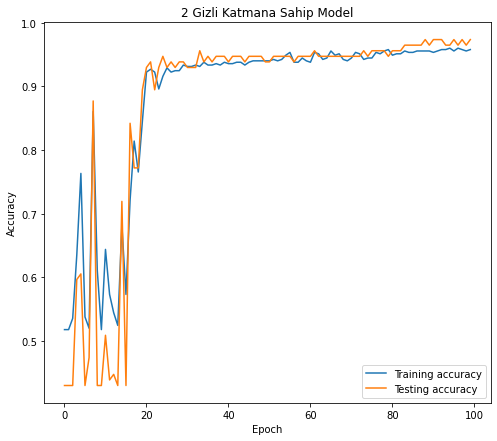

In [18]:
# 1 Gizli katmanlı olarak belirlediğimiz modele bir gizli katman daha eklenerek doğruluk değerinin grafiğinin çizdirilmesi.

model2 = krs.models.Sequential()
model2.add(krs.layers.Dense(units=12,activation="sigmoid", input_dim=43))
model2.add(krs.layers.Dense(units=6,activation="sigmoid"))
model2.add(krs.layers.Dense(units=1,activation="sigmoid"))
optimizer = SGD(lr=0.01,momentum=0.9)
model2.compile(optimizer=optimizer,loss="binary_crossentropy",metrics=['accuracy'])

hist2 = model2.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=32 ,verbose=2)
plt.rcParams["figure.figsize"] = (8,7)
plt.plot(hist2.history['accuracy'], label='Training accuracy')
plt.plot(hist2.history['val_accuracy'], label='Testing accuracy')
plt.title('2 Gizli Katmana Sahip Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

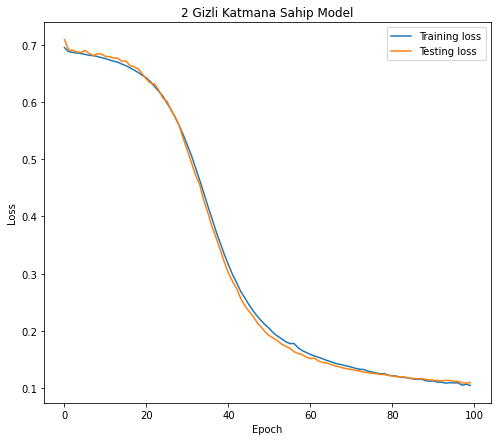

In [23]:
# 1 Gizli katmanlı olarak belirlediğimiz modele bir gizli katman daha eklenerek hata değerinin grafiğinin çizdirilmesi.
plt.plot(hist2.history['loss'], label='Training loss')
plt.plot(hist2.history['val_loss'], label='Testing loss')
plt.title('2 Gizli Katmana Sahip Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

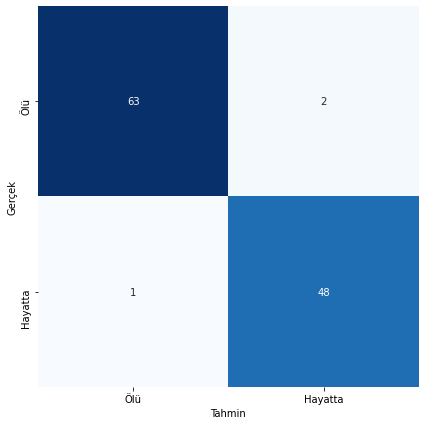

In [21]:
# En iyi sonucu veren 1 gizli katmana sahip, “sigmoid” aktivasyon fonksiyonunu kullanan, 0.9 momentum katsayısı ve
# 0.01 öğrenme oranına sahip modelin karmaşıklık matrisinin çizdirilmesi.

y_predicted = model1.predict(X_test) > 0.5
mat = confusion_matrix(Y_test, y_predicted)
labels = ['Ölü', 'Hayatta']
 
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)
 
plt.xlabel('Tahmin')
plt.ylabel('Gerçek')
plt.show()